# Imports

In [1]:
from fastai.vision.all import *
import wandb
from fastai.callback.wandb import *

In [2]:
wandb.login()

True

# Load Data

In [3]:
path = Path('/storage/data/kaggle-melanoma'); path.ls()

(#5) [Path('/storage/data/kaggle-melanoma/siim-isic-melanoma-classification.zip'),Path('/storage/data/kaggle-melanoma/train.csv'),Path('/storage/data/kaggle-melanoma/sample_submission.csv'),Path('/storage/data/kaggle-melanoma/test.csv'),Path('/storage/data/kaggle-melanoma/jpeg')]

In [4]:
path_images = path/'jpeg'/'train'
path_images.ls()

(#33126) [Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_5990639.jpg'),Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_8654660.jpg'),Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_3899323.jpg'),Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_4618918.jpg'),Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_2429070.jpg'),Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_5069715.jpg'),Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_0283541.jpg'),Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_2945324.jpg'),Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_9613570.jpg'),Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_7185913.jpg')...]

## EDA

In [5]:
df_train = pd.read_csv(path/'train.csv');  len(df_train)

33126

In [6]:
df_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [7]:
df_train.describe(include='all')

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
count,33126,33126,33061,33058.000000,32599,33126,33126,33126.000000
unique,33126,2056,2,NaN,6,9,2,NaN
top,ISIC_0641480,IP_4382720,male,NaN,torso,unknown,benign,NaN
freq,1,115,17080,NaN,16845,27124,32542,NaN
mean,NaN,NaN,NaN,48.870016,NaN,NaN,NaN,0.017630
std,NaN,NaN,NaN,14.380360,NaN,NaN,NaN,0.131603
min,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,40.000000,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,50.000000,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,60.000000,NaN,NaN,NaN,0.000000


In [8]:
33126*0.0176

583.0176

Interesting, the classes are very unbalanced, much more benign than malignant.

In [9]:
df_test = pd.read_csv(path/'test.csv'); len(df_test)

10982

In [10]:
df_test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [11]:
df_test.describe(include='all')

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
count,10982,10982,10982,10982.000000,10631
unique,10982,690,2,NaN,6
top,ISIC_5050453,IP_3579794,male,NaN,torso
freq,1,240,6255,NaN,5847
mean,NaN,NaN,NaN,49.525587,NaN
std,NaN,NaN,NaN,14.370589,NaN
min,NaN,NaN,NaN,10.000000,NaN
25%,NaN,NaN,NaN,40.000000,NaN
50%,NaN,NaN,NaN,50.000000,NaN
75%,NaN,NaN,NaN,60.000000,NaN


## Look at individual images

<AxesSubplot:>

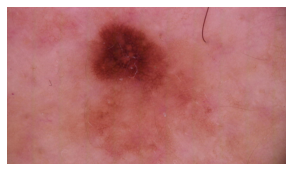

In [12]:
f = get_image_files(path_images)[0]
img = PILImage.create(f)
img.show()

In [13]:
f.stem

'ISIC_5990639'

In [14]:
def get_row(fn): return df_train.loc[df_train['image_name'] == f.stem]
def get_target(fn): return get_row(fn).iloc[0]['target']

In [15]:
get_row(f)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
19726,ISIC_5990639,IP_5439716,male,70.0,torso,nevus,benign,0


In [16]:
get_target(f)

0

## Build DataBlock

### Use a subset of total data

Idea: To model production environment, split train/val by patient ID.

In [17]:
np.random.seed(42)

In [18]:
iteration_patients = np.random.choice(df_train['patient_id'].unique(), size=200, replace=False); len(iteration_patients)

200

In [19]:
iteration_valid_patients = np.random.choice(iteration_patients, size=20, replace=False); len(iteration_valid_patients)

20

In [20]:
df_iteration = df_train[df_train['patient_id'].isin(iteration_patients)].copy()

In [21]:
df_iteration['is_valid'] = df_iteration['patient_id'].isin(iteration_valid_patients)

In [22]:
df_iteration.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,is_valid
30,ISIC_0085718,IP_1264754,female,65.0,torso,unknown,benign,0,False
61,ISIC_0099474,IP_3057277,male,45.0,NaN,unknown,benign,0,False
71,ISIC_0112097,IP_5889408,female,45.0,torso,unknown,benign,0,False
77,ISIC_0124849,IP_0078294,male,60.0,upper extremity,unknown,benign,0,False
78,ISIC_0125706,IP_4096093,female,60.0,torso,unknown,benign,0,False


In [23]:
df_iteration.describe(include='all')

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,is_valid
count,3302,3302,3302,3302.000000,3136,3302,3302,3302.000000,3302
unique,3302,200,2,NaN,6,7,2,NaN,2
top,ISIC_8765435,IP_3057277,female,NaN,torso,unknown,benign,NaN,False
freq,1,102,1682,NaN,1606,2710,3222,NaN,2928
mean,NaN,NaN,NaN,51.603574,NaN,NaN,NaN,0.024228,NaN
std,NaN,NaN,NaN,14.463904,NaN,NaN,NaN,0.153779,NaN
min,NaN,NaN,NaN,15.000000,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,NaN,40.000000,NaN,NaN,NaN,0.000000,NaN
50%,NaN,NaN,NaN,50.000000,NaN,NaN,NaN,0.000000,NaN
75%,NaN,NaN,NaN,60.000000,NaN,NaN,NaN,0.000000,NaN


In [24]:
df_iteration[df_iteration['is_valid'] == True].head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,is_valid
392,ISIC_0230332,IP_8326844,female,70.0,upper extremity,unknown,benign,0,True
406,ISIC_0234049,IP_6071452,male,70.0,torso,unknown,benign,0,True
424,ISIC_0238118,IP_6071452,male,70.0,torso,unknown,benign,0,True
446,ISIC_0243148,IP_2214113,female,55.0,torso,unknown,benign,0,True
519,ISIC_0264941,IP_6071452,male,70.0,lower extremity,unknown,benign,0,True


In [25]:
np.any(df_iteration.image_name.str.contains('.jpg'))

False

In [26]:
df_iteration[df_iteration['is_valid'] == True].describe(include='all')

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,is_valid
count,374,374,374,374.000000,370,374,374,374.000000,374
unique,374,20,2,NaN,5,3,2,NaN,1
top,ISIC_0818621,IP_6071452,female,NaN,torso,unknown,benign,NaN,True
freq,1,87,193,NaN,191,274,365,NaN,374
mean,NaN,NaN,NaN,54.211230,NaN,NaN,NaN,0.024064,NaN
std,NaN,NaN,NaN,14.027196,NaN,NaN,NaN,0.153454,NaN
min,NaN,NaN,NaN,15.000000,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,NaN,45.000000,NaN,NaN,NaN,0.000000,NaN
50%,NaN,NaN,NaN,55.000000,NaN,NaN,NaN,0.000000,NaN
75%,NaN,NaN,NaN,70.000000,NaN,NaN,NaN,0.000000,NaN


## Build DataBlock

In [27]:
data = DataBlock(blocks=(ImageBlock, CategoryBlock(vocab={'benign': 0, 'malignant': 1})),
                get_x=ColReader('image_name', pref=path_images, suff='.jpg'),
                get_y=ColReader('benign_malignant'),
                splitter=ColSplitter())

In [28]:
data = data.new(item_tfms=Resize(440))

## Build Dataloaders

In [44]:
dls = data.dataloaders(df_iteration, bs=64)
len(dls.train_ds), len(dls.valid_ds)

(2928, 374)

## Look at processed data

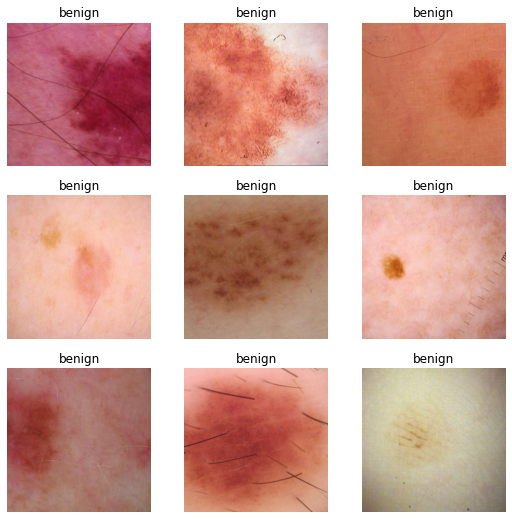

In [30]:
dls.show_batch()

# Modeling

In [45]:
wandb.init(project='melanoma-classification')

W&B Run: https://app.wandb.ai/bwolfson97/melanoma-classification/runs/3baa6n9k

## Create learner

In [46]:
learn = cnn_learner(dls, resnet18, metrics=RocAucBinary(), cbs=WandbCallback(log_model=False))

## Get fine_tune baseline

In [47]:
learn.fine_tune(2)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f043d6e71f0>
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/envs/fastai/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/envs/fastai/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/conda/envs/fastai/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/opt/conda/envs/fastai/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


WandbCallback was not able to get prediction samples -> 'Learner' object has no attribute 'preds'


RuntimeError: CUDA out of memory. Tried to allocate 758.00 MiB (GPU 0; 15.78 GiB total capacity; 12.96 GiB already allocated; 183.94 MiB free; 14.40 GiB reserved in total by PyTorch)

## LR Finder

## Train head

## Unfreeze & Find new LR

## Train entire model w/discriminative LR

# Analysis

In [ ]:
interp = ClassificationInterpreter.from_learner(learn)

## Confusion matrix

In [ ]:
interp.plot_confusion_matrix()

## Top Losses

In [ ]:
interp.plot_top_losses()

## Clean up dataset??

# Submit

## Generate predictions

## Format correctly

## Write to CSV

## Submit! :)